<a href="https://colab.research.google.com/github/Aljawharah23/DeepLearningProject/blob/main/DLproject.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [4]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [5]:
!pip install torch torchvision torchaudio --upgrade


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 670.2/670.2 MB 1.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.8/6.8 MB 71.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.3/3.3 MB 53.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.7/23.7 MB 20.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 823.6/823.6 kB 42.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.1/14.1 MB 59.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 731.7/731.7 MB 726.8 kB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 410.6/410.6 MB 2.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 121.6/121.6 MB 8.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.5/56.5 MB 10.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 124.2/124.2 MB 8.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 196.0/196.0 MB 3.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━

Looking in folder: /content/drive/My Drive/Colab Notebooks/BraTS20_Training_001
Loaded 4 image(s) and 1 mask(s).
Looking in folder: /content/drive/My Drive/Colab Notebooks/BraTS20_Validation_001
Loaded 4 image(s) and 0 mask(s).
Epoch [1/10], Loss: 0.6824, Val Loss: 0.6569
Epoch [2/10], Loss: 0.6709, Val Loss: 0.5534
Epoch [3/10], Loss: 0.6537, Val Loss: 0.5171
Epoch [4/10], Loss: 0.6587, Val Loss: 0.5666
Epoch [5/10], Loss: 0.6463, Val Loss: 0.6064
Epoch [6/10], Loss: 0.6516, Val Loss: 0.6227
Epoch [7/10], Loss: 0.6451, Val Loss: 0.6044
Epoch [8/10], Loss: 0.6404, Val Loss: 0.6024
Epoch [9/10], Loss: 0.6352, Val Loss: 0.5892
Epoch [10/10], Loss: 0.6179, Val Loss: 0.5857


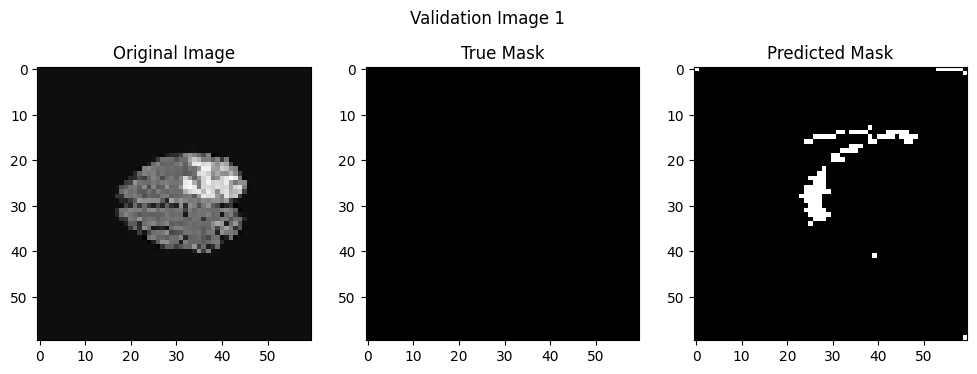

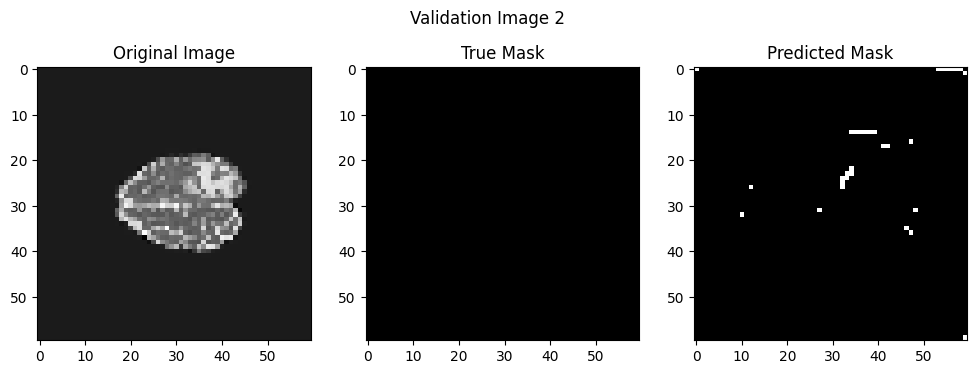

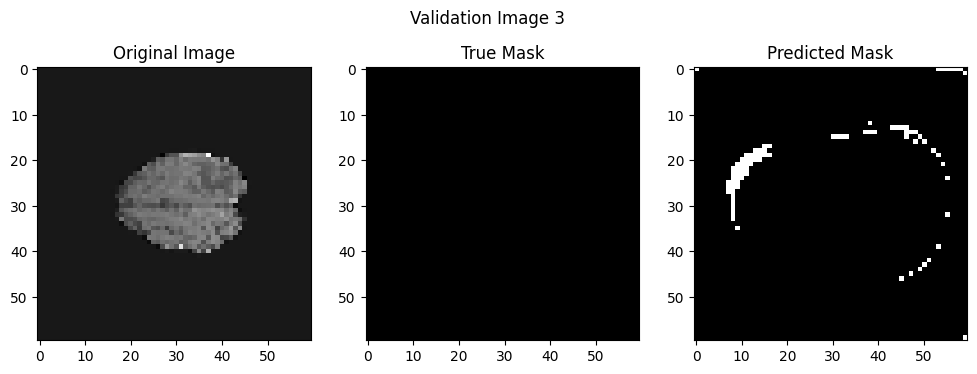

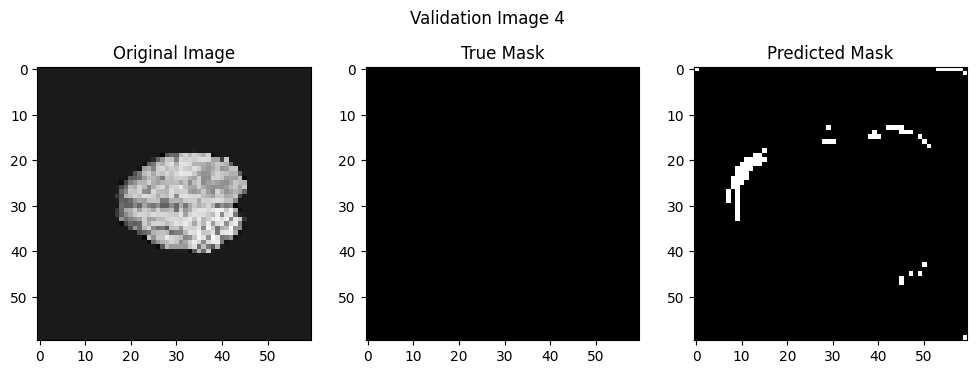

In [3]:
import os
import nibabel as nib
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torch.cuda.amp import GradScaler, autocast
from scipy.ndimage import zoom
import matplotlib.pyplot as plt

# Function to resize the 3D volume
def resize_volume(data, new_shape=(120, 120, 77)):
    resize_factor = np.array(new_shape) / np.array(data.shape)
    resized_data = zoom(data, resize_factor, mode='nearest')
    return resized_data

def load_nifti_with_mask_to_tensor(folder_path, new_shape=(120, 120, 77)):
    image_tensor_list = []
    mask_tensor_list = []
    print(f"Looking in folder: {folder_path}")

    for file_name in os.listdir(folder_path):
        if file_name.lower().endswith('.nii'):
            file_path = os.path.join(folder_path, file_name)
            try:
                img = nib.load(file_path)
                data_array = img.get_fdata(dtype=np.float32)
                resized_data_array = resize_volume(data_array, new_shape=(60, 60, 39))
                data_tensor = torch.from_numpy(resized_data_array).unsqueeze(0)
                if 'seg' in file_name.lower():
                    mask_tensor_list.append(data_tensor)
                else:
                    image_tensor_list.append(data_tensor)
            except Exception as e:
                print(f"Error loading file {file_path}: {e}")

    print(f"Loaded {len(image_tensor_list)} image(s) and {len(mask_tensor_list)} mask(s).")
    return image_tensor_list, mask_tensor_list

class NiftiDataset(Dataset):
    def __init__(self, image_tensor_list, mask_tensor_list=None):
        self.image_tensor_list = image_tensor_list
        self.mask_tensor_list = mask_tensor_list

        if self.mask_tensor_list is None:
            self.mask_tensor_list = [None] * len(self.image_tensor_list)
        while len(self.mask_tensor_list) < len(self.image_tensor_list):
            self.mask_tensor_list.append(None)

    def __len__(self):
        return len(self.image_tensor_list)

    def __getitem__(self, idx):
        image = self.image_tensor_list[idx]
        mask = self.mask_tensor_list[idx] if self.mask_tensor_list[idx] is not None else torch.zeros_like(image)
        return image, mask

class UNet3D(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(UNet3D, self).__init__()
        self.encoder1 = self.conv_block(in_channels, 8)
        self.encoder2 = self.conv_block(8, 16)
        self.encoder3 = self.conv_block(16, 32)
        self.encoder4 = self.conv_block(32, 64)
        self.bottleneck = self.conv_block(64, 128)
        self.decoder4 = self.conv_block(128 + 64, 64)
        self.decoder3 = self.conv_block(64 + 32, 32)
        self.decoder2 = self.conv_block(32 + 16, 16)
        self.decoder1 = self.conv_block(16 + 8, 8)
        self.final_conv = nn.Conv3d(8, out_channels, kernel_size=1)


    def conv_block(self, in_channels, out_channels):
        block = nn.Sequential(
            nn.Conv3d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv3d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.BatchNorm3d(out_channels)
        )
        return block

    def forward(self, x):
        enc1 = self.encoder1(x)
        enc2 = self.encoder2(enc1)
        enc3 = self.encoder3(enc2)
        enc4 = self.encoder4(enc3)
        bottleneck = self.bottleneck(enc4)
        dec4 = self.decoder4(torch.cat((bottleneck, enc4), dim=1))
        dec3 = self.decoder3(torch.cat((dec4, enc3), dim=1))
        dec2 = self.decoder2(torch.cat((dec3, enc2), dim=1))
        dec1 = self.decoder1(torch.cat((dec2, enc1), dim=1))
        return self.final_conv(dec1)

def visualize_segmentation(image_tensor, mask_tensor, output_tensor, index):

    slice_idx = image_tensor.shape[2] // 2  # here to get the middle slice

    image_slice = image_tensor[0, 0, :, :, slice_idx].cpu().numpy()
    mask_slice = mask_tensor[0, 0, :, :, slice_idx].cpu().numpy() if mask_tensor is not None else None
    output_slice = output_tensor[0, 0, :, :, slice_idx].cpu().numpy()

    plt.figure(figsize=(12, 4))
    plt.subplot(1, 3, 1)
    plt.imshow(image_slice, cmap='gray')
    plt.title('Original Image')
    plt.subplot(1, 3, 2)
    plt.imshow(mask_slice, cmap='gray')
    plt.title('True Mask')
    plt.subplot(1, 3, 3)
    plt.imshow(output_slice, cmap='gray')
    plt.title('Predicted Mask')
    plt.suptitle(f'Validation Image {index}')
    plt.show()


def segment_validation_images(model, loader, device):
    model.eval()
    with torch.no_grad():
        for i, (val_inputs, val_masks) in enumerate(loader):
            val_inputs, val_masks = val_inputs.to(device), val_masks.to(device)
            val_outputs = model(val_inputs)
            val_probs = torch.sigmoid(val_outputs)
            val_preds = (val_probs > 0.5).float()
            if i < 5:
                visualize_segmentation(val_inputs, val_masks, val_preds, i+1)

if __name__ == "__main__":
    device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
    train_folder_path = '/content/drive/My Drive/Colab Notebooks/BraTS20_Training_001'
    test_folder_path = '/content/drive/My Drive/Colab Notebooks/BraTS20_Validation_001'
    train_image_tensor_list, train_mask_tensor_list = load_nifti_with_mask_to_tensor(train_folder_path)
    test_image_tensor_list, _ = load_nifti_with_mask_to_tensor(test_folder_path, new_shape=(120, 120, 77))
    train_loader = DataLoader(NiftiDataset(train_image_tensor_list, train_mask_tensor_list), batch_size=1, shuffle=True)
    test_loader = DataLoader(NiftiDataset(test_image_tensor_list), batch_size=1)
    model = UNet3D(in_channels=1, out_channels=1).to(device)
    criterion = nn.BCEWithLogitsLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    scaler = GradScaler()
    num_epochs = 10
    for epoch in range(num_epochs):
        model.train()
        for inputs, masks in train_loader:
            inputs, masks = inputs.to(device), masks.to(device)
            optimizer.zero_grad()
            with autocast():
                outputs = model(inputs)
                loss = criterion(outputs, masks)
            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()
            torch.cuda.empty_cache()
        model.eval()
        val_loss = 0.0
        with torch.no_grad():
            for val_inputs, val_masks in test_loader:
                val_inputs, val_masks = val_inputs.to(device), val_masks.to(device)
                val_outputs = model(val_inputs)
                val_loss += criterion(val_outputs, val_masks).item()
        val_loss /= len(test_loader)
        print(f'Epoch [{epoch + 1}/{num_epochs}], Loss: {loss.item():.4f}, Val Loss: {val_loss:.4f}')
    torch.save(model.state_dict(), 'model.pth')
    segment_validation_images(model, test_loader, device)


In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive
